In [1]:
%matplotlib inline

import os

from pathlib import Path

if "models" in Path.cwd().parts:
    while "models" in Path.cwd().parts:
        os.chdir('..')

In [2]:
# os.chdir('d:/projects/python/formdet') #todo: will fix it

In [3]:
Path.cwd()

PosixPath('/root/objectdet-check/formdet')

In [4]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2', '3'}
import tensorflow as tf

tf.autograph.set_verbosity(1)
tf.get_logger().setLevel('ERROR')

from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display


from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import time
from object_detection.utils import config_util
from object_detection.builders import model_builder


In [5]:
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  2
Default GPU Device: /device:GPU:0


# Model preparation & loading

In [6]:
# model_dir = Path('/home/ubuntu/formsdet/.trained_models/')
model_dir = Path('/root/objectdet-check/')

labels_file = model_dir / 'label_map2.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(labels_file, use_display_name=True)


In [7]:
pipeline_path = model_dir / "ssd_efficientdet_d4_1024x1024_coco17_tpu-32.config"
# checkpoint_path = model_dir / "checkpoint"

print('Loading model... ', end='')

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(str(pipeline_path))
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
# ckpt.restore(str(model_dir / '.checkpoints' / 'ckpt-41')).expect_partial()
ckpt.restore(str(model_dir / '.checkpoints.bd' / 'ckpt-101')).expect_partial()



Loading model... Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandle

### category index

In [8]:
category_index

{1: {'id': 1, 'name': 'text'},
 2: {'id': 2, 'name': 'checkmark'},
 3: {'id': 3, 'name': 'radio'},
 4: {'id': 4, 'name': 'date'},
 5: {'id': 5, 'name': 'signature'},
 6: {'id': 6, 'name': 'number'},
 7: {'id': 7, 'name': 'cells'},
 8: {'id': 8, 'name': 'unknown'}}

## detect fn

In [9]:
@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

# Experiments

In [10]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


def process_image(image_path):

    print(f'Running inference for {image_path}... ', end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    print(f'num detections:{num_detections}')

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy() ##???

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=900,
            min_score_thresh=.09,
            agnostic_mode=False)

    return image_np_with_detections
   
# img = process_image('/root/objectdet-check/data/3055/pages/page-2.png')
# img = process_image('/root/objectdet-check/data/2157/pages/page-1.png')
# D:\projects\python\formdet\totaldat\1319500\pages\page-1.png   
# img = process_image('/root/objectdet-check/data/100356/pages/page-1.png')
# img = process_image('/root/objectdet-check/data/1244199/pages/page-1.png')
img = process_image('/root/objectdet-check/data/1319500/pages/page-1.png')


Running inference for /root/objectdet-check/data/1319500/pages/page-1.png... Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in devic

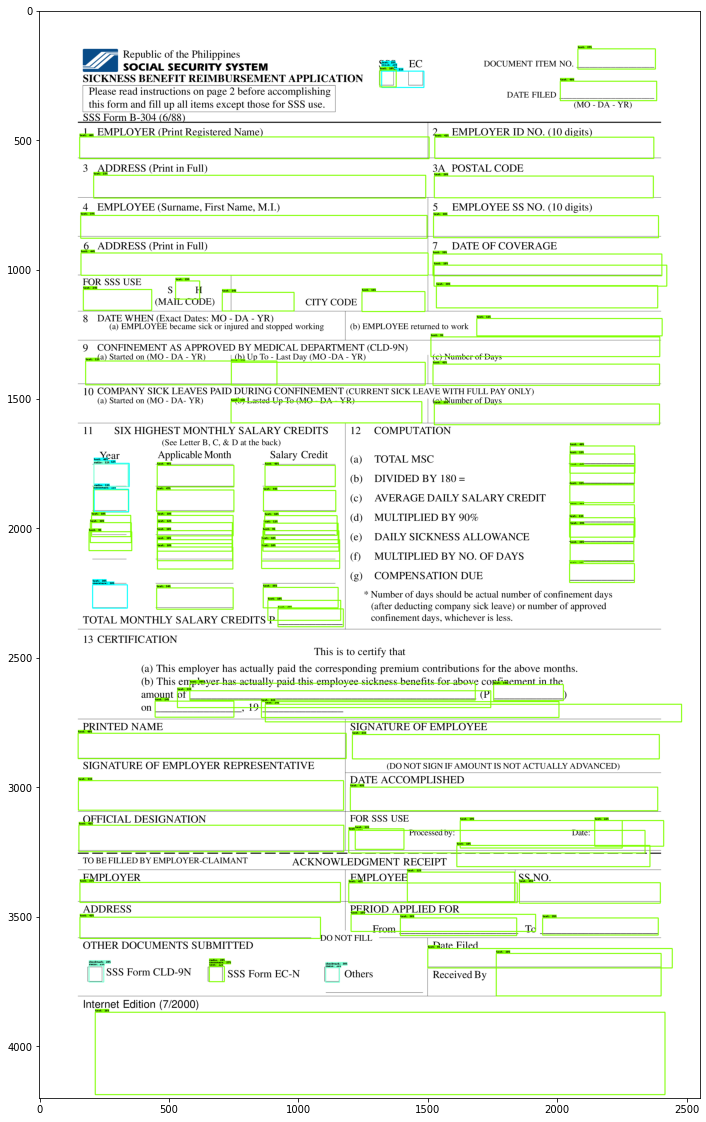

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(img)
#     print('Done')
plt.savefig('object_labels.png', bbox_inches='tight')
plt.show()


## debug code

In [16]:
image_path = '/root/objectdet-check/data/1319500/pages/page-1.png'
print(f'Running inference for {image_path}... ', end='')

image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
print(f'num detections:{num_detections}')

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# viz_utils.visualize_boxes_and_labels_on_image_array(
#         image_np_with_detections,
#         detections['detection_boxes'],
#         detections['detection_classes']+label_id_offset,
#         detections['detection_scores'],
#         category_index,
#         use_normalized_coordinates=True,
#         max_boxes_to_draw=900,
#         min_score_thresh=.017,
#         agnostic_mode=False)



Running inference for /root/objectdet-check/data/1319500/pages/page-1.png... Executing op __inference_detect_fn_29934 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
num detections:900


In [17]:
category_index[1]['name']

'text'

# New draw detections function

In [18]:
type_to_color = {
#     'unknown': 'black',
#     'text':'lime',
#     'number': 'mediumblue',
#     'date':'magenta',
#     'cells':'yellow',
#     'image':'orangered',
#     'dropdown':'orangered',
#     'checkmark_X':'gold',
#     'checkmark_V':'red',
#     'checkmark_O':'slategray',
#     'radio':'dodgerblue',
#     'signature':'darkviolet',
    8: 'black',
    1:'green',
    6: 'mediumblue',
    4:'magenta',
    7:'yellow',
#     'image':'orangered',
#     'dropdown':'orangered',
#     'checkmark_X':'gold',
#     'checkmark_V':'red',
#     'checkmark_O':'slategray',
    2:'gold',
    3:'dodgerblue',
    5:'darkviolet',
}


In [19]:
type_to_color[2]

'gold'

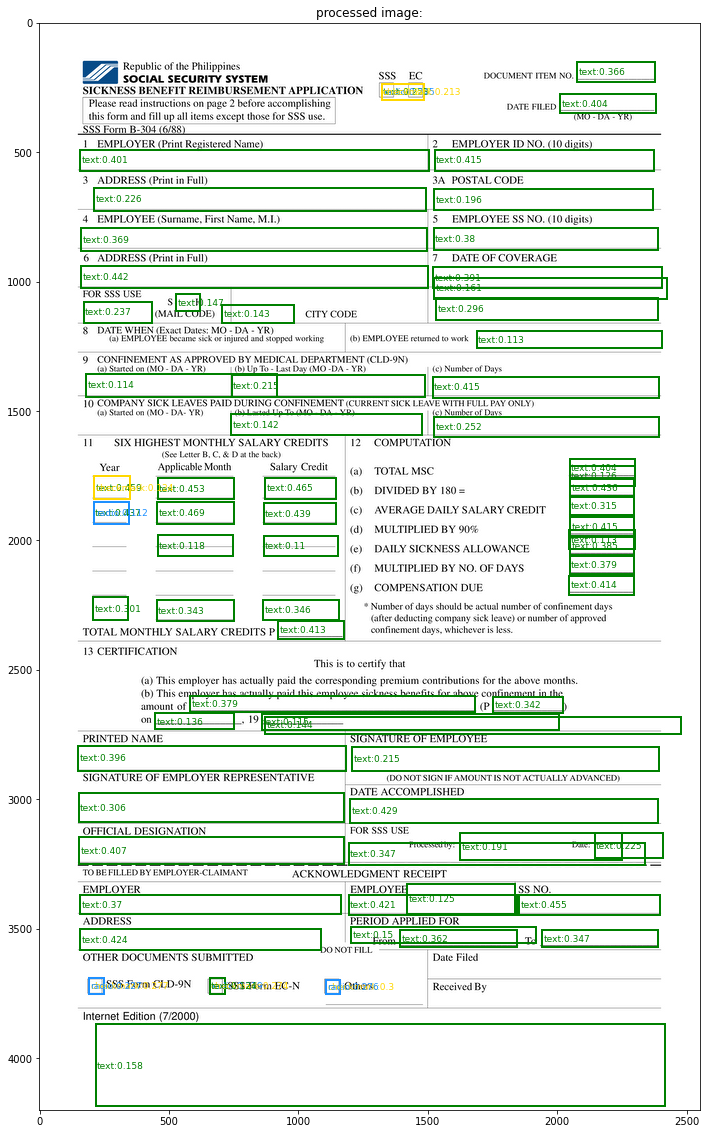

In [21]:
from matplotlib.patches import Circle, Rectangle
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow, subplots
from matplotlib.colors import to_hex

image = Image.open(image_path)
width, height = image.size

fig, ax = subplots(figsize=(20, 20))
ax.set_title('processed image:')
imp = ax.imshow(image, interpolation='lanczos')
# imp = ax.imshow(image)
ax.axis('on')

# ax.text(100,300, 'test', ha='center', va='center', fontsize=10, color='red')
cc = 300./96.
for box, class_i, score in zip(detections['detection_boxes'], detections['detection_classes']+label_id_offset, detections['detection_scores']):
    if score > .11:
        x = box[1] * width
        y = box[0] * height
        w = (box[3]-box[1]) * width
        h = (box[2]-box[0]) * height
        ax.add_patch(Rectangle((x, y), w, h, fill=False, color=type_to_color[class_i], linewidth=2, 
#                                hatch='//'
                              ))
        ax.text(
            # x+0.5*w, y+0.5*h, 
            x+5, y+0.5*h, 
            f"{category_index[class_i]['name']}:{score:.3}", 
            ha='left', va='center', 
            fontsize=9, 
            color=type_to_color[class_i], 
#                 bbox=dict(color='white',facecolor='white', alpha=0.9)
        )


In [84]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

class ScoredRectangle:
    def __init__(self, b, score=None, label=None):
        self.x1 = b[1]
        self.y1 = b[0]
        self.x2 = b[3]
        self.y2 = b[2]
        self.score = score
        self.label = label

    def is_intersect(self, other):
        if self.x1 > other.x2 or self.x2 < other.x1:
            return False
        if self.y1 > other.y2 or self.y2 < other.y1:
            return False
        return True
    
    def intersect(self, r):        
        x1 = max(self.x1, r.x1)
        y1 = max(self.y1, r.y1)
        x2 = min(self.x2, r.x2)
        y2 = min(self.y2, r.y2)
        
        return ScoredRectangle([y1,x1,y2,x2])
    
    def area(self,):
        return (self.x2-self.x1)*(self.y2-self.y1)
    
    def size(self, ):
        return (self.x2-self.x1, self.y2-self.y1)
    
    def mul(self, page_width, page_height):
        self.x1 = self.x1 * page_width
        self.x2 = self.x2 * page_width
        self.y1 = self.y1 * page_height
        self.y2 = self.y2 * page_height
        
    def __str__(self):
        return f'x1:{self.x1} x2:{self.x2} y1:{self.y1} y2:{self.y2} size:{self.size()}'
        
        
def get_iou_boxes(r1: ScoredRectangle, r2: ScoredRectangle):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Returns
    -------
    float
        in [0, 1]
    """
#     r1 = Rectangle(b1)
#     r2 = Rectangle(b2)
    
    rr = r1.intersect(r2)
    
    if rr.x2 < rr.x1 or rr.y2 < rr.y1:
        return 0.0
    
    a1 = r1.area()
    a2 = r2.area()
    ra = float(rr.area())
#     iou = ra / float(a1+a2-ra)
    iou = max(ra/a1, ra/a2)
    return iou
    

## draw detection

In [85]:
def draw_detections(ax, pillow_image, threshold=0.15, print_annotation=True, lowest_threshold=.1, iou_threshold=1.):
    image = pillow_image
    width, height = image.size 
    
    image_np = np.array(image)
 
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
#     print(f'num detections:{num_detections}')

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    ax.set_title(f'processed (num detections={num_detections}, thrsh={threshold}): ')
    imp = ax.imshow(image)
    ax.axis('on')

    list_boxes = []
#     lowest_threshold = .1
    for box, class_i, score in zip(detections['detection_boxes'], detections['detection_classes']+label_id_offset, detections['detection_scores']):
        if score > lowest_threshold:
            r = ScoredRectangle(box, score=score, label=class_i)
            r.mul(width, height)
            list_boxes.append(r)
    
    print(f'total boxes:{len(list_boxes)}')
#     print(f'iou:{get_iou_boxes(list_boxes[1], list_boxes[2])}  -- ')
#     print(f'\t 1[{list_boxes[1]}] -- 2[{list_boxes[2]}]\n\tintersect: {list_boxes[1].intersect(list_boxes[2])}')
    
    #     iou_threshold = 1
    filtered_boxes = []
    list_boxes.reverse()
    for i, r1 in enumerate(list_boxes):

        for r2 in list_boxes[i+1:]:
            iou = get_iou_boxes(r1, r2)
#             print(f'{i} iou={iou}')
            if iou > iou_threshold:
                print(f'{i} iou={iou} scores:{r1.score} {r2.score}')
                if r1.score < r2.score:
                    print(f'break:{r1.score}<{r2.score}')
                    break
        else:
            filtered_boxes.append(r1)
                
    print(f'filtered boxes:{len(filtered_boxes)}')
        
        
    for r in filtered_boxes:
        x = r.x1
        y = r.y1
        w, h = r.size()
    
        ax.add_patch(Rectangle((x, y), w, h, fill=False, color=type_to_color[r.label], linewidth=2, 
            hatch='//'
        ))
        if print_annotation:
            ax.text(
                # x+0.5*w, y+0.5*h, 
                x+5, y+0.5*h, 
                f"{category_index[r.label]['name']}:{r.score:.3}", 
                ha='left', va='center', 
                fontsize=9, 
                color=type_to_color[r.label], 
                # bbox=dict(color='white',facecolor='white', alpha=0.95)
            )
    

#     for box, class_i, score in zip(detections['detection_boxes'], detections['detection_classes']+label_id_offset, detections['detection_scores']):
#         if score > threshold:
#             x = box[1] * width
#             y = box[0] * height
#             w = (box[3]-box[1]) * width
#             h = (box[2]-box[0]) * height
            
#             ax.add_patch(Rectangle((x, y), w, h, fill=False, color=type_to_color[class_i], linewidth=2, 
#                 hatch='//'
#             ))
#             if print_annotation:
#                 ax.text(
#                     # x+0.5*w, y+0.5*h, 
#                     x+5, y+0.5*h, 
#                     f"{category_index[class_i]['name']}:{score:.3}", 
#                     ha='left', va='center', 
#                     fontsize=9, 
#                     color=type_to_color[class_i], 
#                     # bbox=dict(color='white',facecolor='white', alpha=0.95)
#                 )


## tests

Executing op __inference_detect_fn_29934 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
total boxes:117
0 iou=0.8663646774226336 scores:0.0804862305521965 0.1260939985513687
break:0.0804862305521965<0.1260939985513687
1 iou=1.0 scores:0.08057642728090286 0.08063799142837524
break:0.08057642728090286<0.08063799142837524
3 iou=0.5283291950237363 scores:0.0808040201663971 0.10520420223474503
break:0.0808040201663971<0.105204

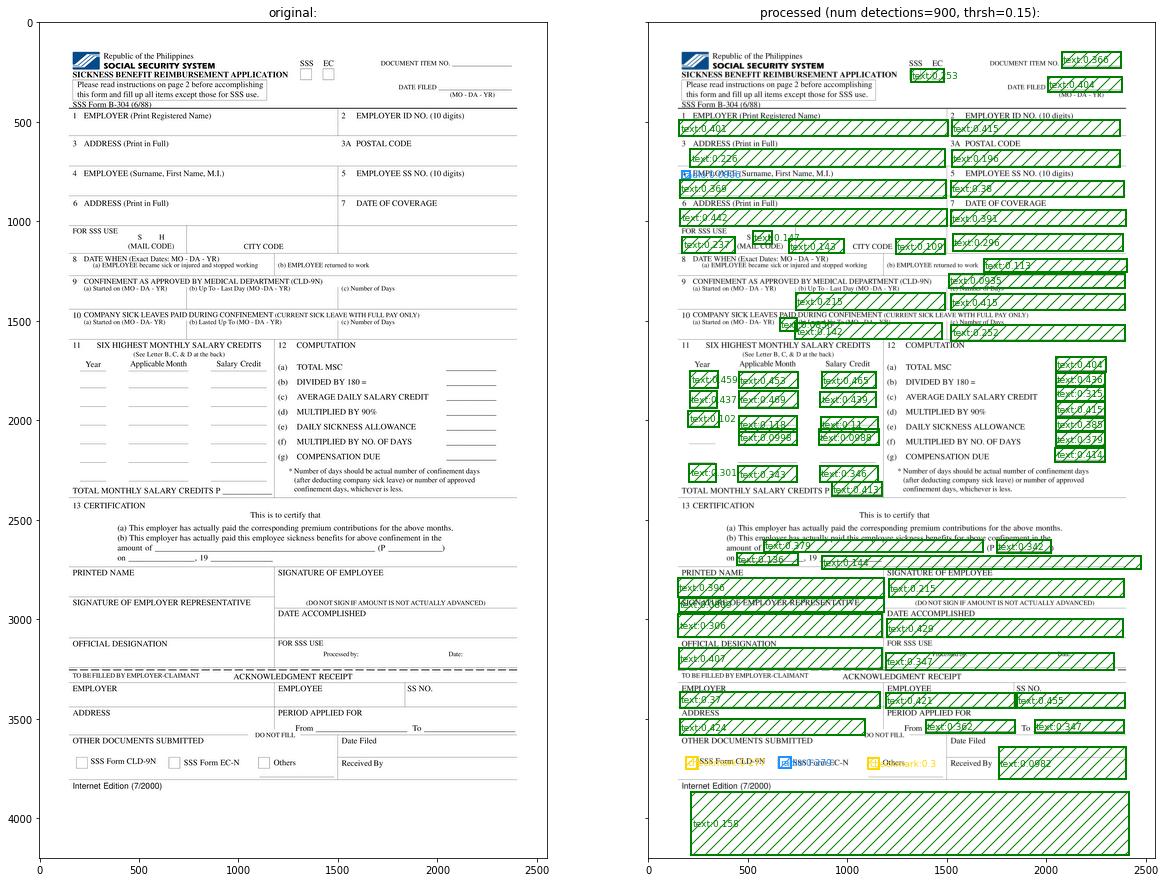

In [91]:
# img = process_image('/root/objectdet-check/data/100356/pages/page-1.png')
# img = process_image('/root/objectdet-check/data/1244199/pages/page-1.png')
# image_path = '/root/objectdet-check/data/1319500/pages/page-1.png'
# image_path = '/root/objectdet-check/data/3055/pages/page-2.png' # wo rects
# image_path = '/root/objectdet-check/data/1244199/pages/page-1.png'
# image_path = '/root/objectdet-check/data/100356/pages/page-1.png'
# image_path = '/root/objectdet-check/bigdat/11/pages/page-1.png'
# image_path = '/root/objectdet-check/bigdat/29/pages/page-1.png'

def _image_path(num, dtype='bigdat', page=1):
    return Path('/root/objectdet-check/') / dtype / f'{num}'/ 'pages' / f'page-{page}.png'

# image_path = _image_path(29)
# image_path = _image_path(354)
# image_path = _image_path(4167)
# image_path = _image_path(115879)


image = Image.open(image_path)
fig, axs = plt.subplots(1, 2, figsize=(20, 20), sharey=True)
axs[0].set_title('original:')
axs[0].imshow(image, interpolation='lanczos')
draw_detections(axs[1], image, lowest_threshold=0.08, iou_threshold=0.2)

# Old, draw page

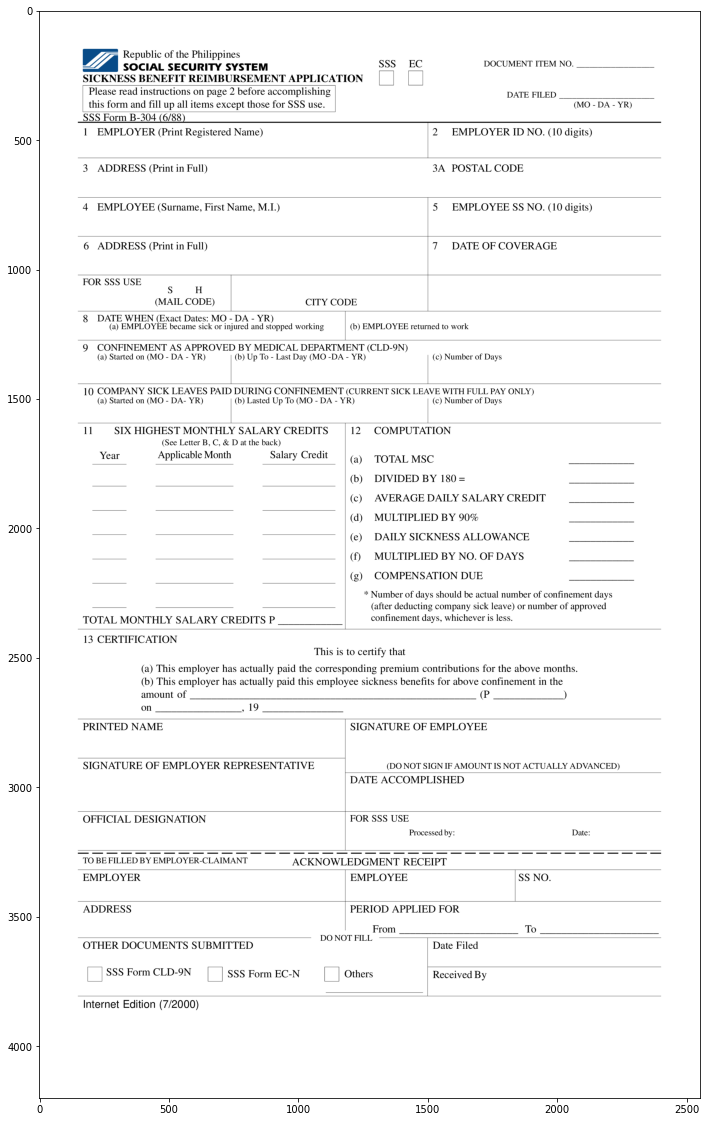

In [45]:
%matplotlib inline
original_image = np.array(Image.open('/root/objectdet-check/data/1319500/pages/page-1.png'))
plt.figure(figsize=(20,20))
plt.imshow(original_image)
plt.show()